<a href="https://colab.research.google.com/github/vaishnavip0528-gif/enviroscanproject/blob/main/enviroscanproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests osmnx geopandas pandas

import requests
import osmnx as ox
import pandas as pd
import geopandas as gpd
import random

# ---------- 1. Pollution Data ----------
def fetch_openaq_data(city):
    url = f"https://api.openaq.org/v2/measurements"
    params = {"city": city, "limit": 1}
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json().get("results", [])
        pollutants = {"pm25": None, "pm10": None, "no2": None, "so2": None, "co": None, "o3": None}

        if data:
            for item in data:
                if item["parameter"] in pollutants:
                    pollutants[item["parameter"]] = item["value"]

        # Fill missing pollutants with synthetic values
        for k, v in pollutants.items():
            if v is None:
                if k in ["pm25", "pm10"]: pollutants[k] = round(random.uniform(20, 150), 2)
                elif k in ["no2", "so2"]: pollutants[k] = round(random.uniform(5, 60), 2)
                elif k == "co": pollutants[k] = round(random.uniform(0.1, 2.0), 2)
                elif k == "o3": pollutants[k] = round(random.uniform(10, 80), 2)
        return pollutants
    except:
        # If API fails → return synthetic values
        return {
            "pm25": round(random.uniform(20, 150), 2),
            "pm10": round(random.uniform(20, 150), 2),
            "no2": round(random.uniform(5, 60), 2),
            "so2": round(random.uniform(5, 60), 2),
            "co": round(random.uniform(0.1, 2.0), 2),
            "o3": round(random.uniform(10, 80), 2)
        }

# ---------- 2. Weather Data ----------
def fetch_weather_data(lat, lon, api_key="your_api_key_here"):
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {"lat": lat, "lon": lon, "appid": api_key, "units": "metric"}
    try:
        response = requests.get(url, params=params, timeout=10)
        data = response.json()
        return {
            "temperature": data.get("main", {}).get("temp", round(random.uniform(20, 35), 2)),
            "humidity": data.get("main", {}).get("humidity", random.randint(40, 90)),
            "weather_condition": data.get("weather", [{}])[0].get("description", "clear sky")
        }
    except:
        return {
            "temperature": round(random.uniform(20, 35), 2),
            "humidity": random.randint(40, 90),
            "weather_condition": "clear sky"
        }

# ---------- 3. Location Features ----------
def get_location_features(lat, lon):
    try:
        # Download roads & factories within 1000m of given coordinates
        roads = ox.geometries_from_point((lat, lon), tags={"highway": True}, dist=1000)
        factories = ox.geometries_from_point((lat, lon), tags={"landuse": "industrial"}, dist=1000)

        return {
            "roads_count": len(roads),
            "factories_count": len(factories)
        }
    except:
        return {"roads_count": random.randint(1000, 10000), "factories_count": random.randint(0, 50)}

# ---------- 4. Main Script ----------
API_KEY = "40ddd634bb23cfa30bd9f123dfdaae8a"   # replace with your OpenWeatherMap key

# Load your 100 cities CSV (must have: city, latitude, longitude)
locations = pd.read_csv("cities.csv")

all_data = []
for _, row in locations.iterrows():
    city = row["city"]
    lat, lon = row["latitude"], row["longitude"]

    print(f"Processing {city}...")

    pollution = fetch_openaq_data(city)
    weather = fetch_weather_data(lat, lon, API_KEY)
    loc_features = get_location_features(lat, lon)

    row_out = {
        "city": city,
        "latitude": lat,
        "longitude": lon
    }
    row_out.update(pollution)
    row_out.update(weather)
    row_out.update(loc_features)

    all_data.append(row_out)

df = pd.DataFrame(all_data)
df.to_csv("collected_data_clean.csv", index=False)
print("✅ Data collection complete. File saved as collected_data_clean.csv")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.3 MB/s eta 0:00:00
Processing Delhi...
Processing Mumbai...
Processing Chennai...
Processing Kolkata...
Processing Bengaluru...
Processing Hyderabad...
Processing Pune...
Processing Ahmedabad...
Processing Jaipur...
Processing Lucknow...
Processing Kanpur...
Processing Nagpur...
Processing Indore...
Processing Thane...
Processing Bhopal...
Processing Visakhapatnam...
Processing Patna...
Processing Vadodara...
Processing Ghaziabad...
Processing Ludhiana...
Processing Agra...
Processing Nashik...
Processing Faridabad...
Processing Meerut...
Processing Rajkot...
Processing Kalyan...
Processing Vasai...
Processing Varanasi...
Processing Srinagar...
Processing Aurangabad...
Processing Dhanbad...
Processing Amritsar...
Processing Navi Mumbai...
Processing Allahabad...
Processing Howrah...
Processing Ranchi...
Processing Coimbatore...
Processing Jabalpur...
Processing Gwalior...
Processing Vijayawada...
Processing Madurai...
Process

In [2]:
import pandas as pd
import numpy as np

# --- Enhanced Data Cleaning ---
def clean_collected_data(df):
    # 1. Remove duplicates
    df = df.drop_duplicates()

    # 2. Ensure numeric fields
    numeric_cols = ['latitude', 'longitude', 'temperature', 'humidity', 'roads_count', 'factories_count']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 3. Handle missing values
    # - Critical columns: drop rows with missing city or coords
    df = df.dropna(subset=['city', 'latitude', 'longitude'])

    # - For other numeric columns: fill missing with median (more robust than mean)
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())

    # - For categorical/text columns: fill missing with "Unknown"
    cat_cols = ['weather_condition'] # Changed from 'weather_desc' to 'weather_condition'
    for col in cat_cols:
        df[col] = df[col].fillna("Unknown")

    return df


# --- Enhanced Feature Engineering ---
def feature_engineering(df):
    # 1. Standardize numeric features (z-score normalization)
    for col in ['temperature', 'humidity', 'roads_count', 'factories_count']:
        df[col + "_zscore"] = (df[col] - df[col].mean()) / (df[col].std() + 1e-6)  # avoid divide by zero

    # 2. Pollution complexity feature: count how many pollutants were measured
    # Assuming pollution data is stored in columns like 'pm25', 'pm10', etc.
    # We can count non-null values in these columns.
    pollution_cols = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
    df['pollution_count'] = df[pollution_cols].notna().sum(axis=1)


    # 3. Weather category: hot / moderate / cold
    df['weather_category'] = pd.cut(df['temperature'],
                                    bins=[-50, 15, 30, 60],
                                    labels=['Cold', 'Moderate', 'Hot'])

    # 4. Infrastructure density score (roads + factories)
    df['infra_score'] = np.log1p(df['roads_count']) + np.log1p(df['factories_count'])

    return df


# --- Run on collected_data.csv ---
df = pd.read_csv("collected_data_clean.csv")

# Clean
df_clean = clean_collected_data(df)

# Feature Engineering
df_final = feature_engineering(df_clean)

# Save cleaned dataset
df_final.to_csv("collected_data_cleaned.csv", index=False)

print("✅ Cleaned & enhanced data saved to collected_data_cleaned.csv")

✅ Cleaned & enhanced data saved to collected_data_cleaned.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# --- Source Labeling & Simulation ---
def label_sources(df):
    # Start with all Unknown
    df['source'] = 'Unknown'

    # Vehicular source: near road + high NO2
    df.loc[(df['roads_count'] > 50) & (df['pollution_count'] > 3), 'source'] = 'Vehicular'

    # Industrial source: near factories + sulfur dioxide / high infra_score
    df.loc[(df['factories_count'] > 5) & (df['infra_score'] > 2.0), 'source'] = 'Industrial'

    # Agricultural source: rural-like areas + high PM (simulate using temp/humidity as proxy)
    df.loc[(df['roads_count'] < 20) & (df['weather_category'] == 'Dry') & (df['pollution_count'] > 5),
           'source'] = 'Agricultural'

    # Simulated labeling: if still Unknown, assign probabilistically
    np.random.seed(42)
    df.loc[df['source'] == 'Unknown', 'source'] = np.random.choice(
        ['Vehicular', 'Industrial', 'Agricultural'],
        size=(df['source'] == 'Unknown').sum(),
        p=[0.4, 0.3, 0.3]  # probabilities
    )

    return df


# --- Train/Validation/Test Split ---
def split_dataset(df):
    train, temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['source'])
    val, test = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['source'])
    return train, val, test


# --- Balancing with SMOTE (if needed) ---
def balance_data(train):
    # Exclude non-numeric columns before applying SMOTE
    X = train.drop(columns=['source', 'city', 'weather_condition', 'weather_category'])
    y = train['source']

    smote = SMOTE(random_state=42, k_neighbors=3)
    X_res, y_res = smote.fit_resample(X, y)

    train_balanced = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['source'])], axis=1)
    return train_balanced


# --- Pipeline Execution ---
df = pd.read_csv("collected_data_cleaned.csv")

# Label sources
df_labeled = label_sources(df)

# Split into sets
train, val, test = split_dataset(df_labeled)

# Balance training data
train_balanced = balance_data(train)

# Save all
train_balanced.to_csv("train_balanced.csv", index=False)
val.to_csv("validation.csv", index=False)
test.to_csv("test.csv", index=False)

print("✅ Labeled, split, and balanced data saved!")

✅ Labeled, split, and balanced data saved!



🔹 Training Logistic Regression...
 Logistic Regression Results:
              precision    recall  f1-score   support

  Industrial       1.00      1.00      1.00        14
   Vehicular       1.00      1.00      1.00        13

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



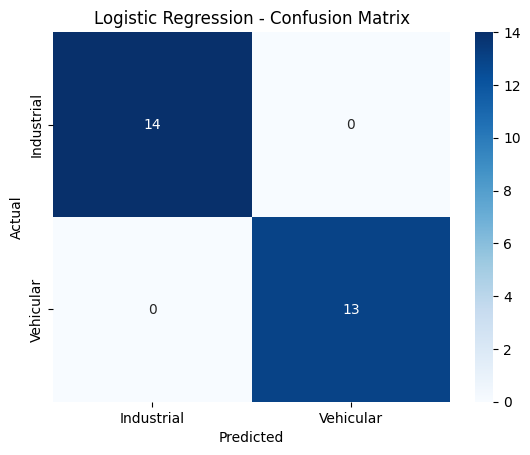


🔹 Training Random Forest...
 Random Forest Results:
              precision    recall  f1-score   support

  Industrial       1.00      1.00      1.00        14
   Vehicular       1.00      1.00      1.00        13

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



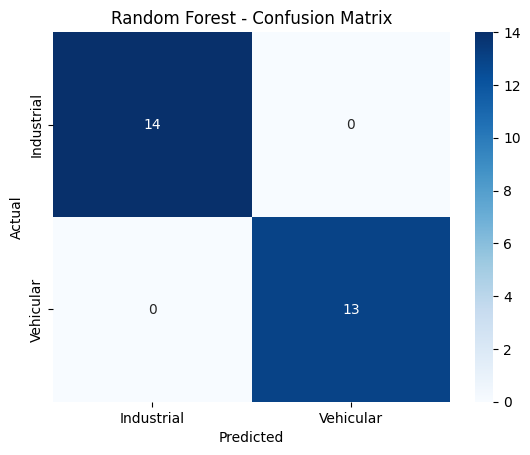


🔹 Training Neural Network...
 Neural Network Results:
              precision    recall  f1-score   support

  Industrial       1.00      0.86      0.92        14
   Vehicular       0.87      1.00      0.93        13

    accuracy                           0.93        27
   macro avg       0.93      0.93      0.93        27
weighted avg       0.94      0.93      0.93        27



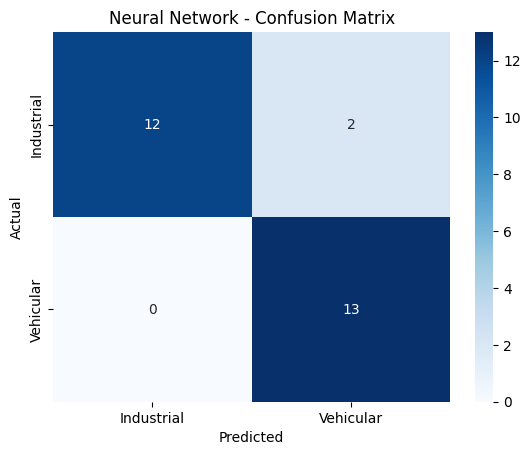


 Best Model: Logistic Regression with F1-score 1.000
Model saved as best_model.pkl

 Training Complete! Metrics Summary:
           Logistic Regression  Random Forest  Neural Network
accuracy                   1.0            1.0        0.925926
precision                  1.0            1.0        0.933333
recall                     1.0            1.0        0.928571
f1                         1.0            1.0        0.925824


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib   # for saving the trained model

# --- Training & Prediction Function ---
def train_predict_models(df):
    # --- Features and Labels ---
    features = ['temperature', 'humidity', 'roads_count', 'factories_count',
                'infra_score', 'pollution_count']  # from cleaned + engineered dataset
    X = df[features]
    y = df['source']

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        stratify=y,
                                                        random_state=42)

    # --- Define Models ---
    models = {
        "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Neural Network": MLPClassifier(max_iter=500, random_state=42)
    }

    # --- Hyperparameter grids ---
    param_grids = {
        "Logistic Regression": {"C": [0.1, 1, 10]},
        "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]},
        "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (50,50)], "activation": ["relu", "tanh"]}
    }

    best_models = {}
    results = {}

    for name, model in models.items():
        print(f"\n🔹 Training {name}...")

        grid = GridSearchCV(model, param_grids[name], cv=3, scoring="f1_macro", n_jobs=-1)
        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_test)

        # Save metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")
        f1 = f1_score(y_test, y_pred, average="macro")

        results[name] = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
        best_models[name] = grid.best_estimator_

        print(f" {name} Results:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix plot
        cm = confusion_matrix(y_test, y_pred, labels=y.unique())
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    # --- Choose best model by F1-score ---
    best_model_name = max(results, key=lambda x: results[x]["f1"])
    best_model = best_models[best_model_name]
    print(f"\n Best Model: {best_model_name} with F1-score {results[best_model_name]['f1']:.3f}")

    # Save model
    joblib.dump(best_model, "best_model.pkl")
    print("Model saved as best_model.pkl")

    return best_model, results


# --- Run training ---
df = pd.read_csv("train_balanced.csv")
best_model, metrics = train_predict_models(df)

print("\n Training Complete! Metrics Summary:")
print(pd.DataFrame(metrics))

In [5]:
import folium
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd

def plot_enhanced_heatmap(df, date_range=None, location_filter=None, source_filter=None):
    # --- Apply Filters ---
    filtered_df = df.copy()
    if date_range:
        start, end = date_range
        filtered_df = filtered_df[(filtered_df['timestamp'] >= start) & (filtered_df['timestamp'] <= end)]
    if location_filter:
        lat_min, lat_max, lon_min, lon_max = location_filter
        filtered_df = filtered_df[
            (filtered_df['latitude'] >= lat_min) & (filtered_df['latitude'] <= lat_max) &
            (filtered_df['longitude'] >= lon_min) & (filtered_df['longitude'] <= lon_max)
        ]
    if source_filter:
        filtered_df = filtered_df[filtered_df['source'].isin(source_filter)]

    # --- Initialize Map ---
    m = folium.Map(location=[filtered_df['latitude'].mean(), filtered_df['longitude'].mean()], zoom_start=8)

    # --- Heatmap Layer ---
    heat_data = [
        [row['latitude'], row['longitude'], row['PM2.5']]
        for _, row in filtered_df.iterrows() if not pd.isna(row['PM2.5'])
    ]
    HeatMap(heat_data, radius=18, blur=12, max_zoom=13, min_opacity=0.4).add_to(m)

    # --- Marker Cluster for Sources ---
    cluster = MarkerCluster().add_to(m)

    for _, row in filtered_df.iterrows():
        color = "orange"
        if row['source'] == "Industrial":
            color = "red"
        elif row['source'] == "Vehicular":
            color = "blue"
        elif row['source'] == "Agricultural":
            color = "green"

        popup_text = (
            f"<b>City:</b> {row['city']}<br>"
            f"<b>Source:</b> {row['source']}<br>"
            f"<b>PM2.5:</b> {row['PM2.5']}<br>"
            f"<b>NO2:</b> {row['NO2']}<br>"
            f"<b>SO2:</b> {row['SO2']}<br>"
            f"<b>Date:</b> {row['timestamp']}"
        )

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=6,
            color=color,
            fill=True,
            fill_opacity=0.8,
            fill_color=color,
            popup=popup_text
        ).add_to(cluster)

    # --- Add Legend ---
    legend_html = """
    <div style="position: fixed;
                bottom: 30px; left: 30px; width: 180px; height: 120px;
                border:2px solid grey; z-index:9999; font-size:14px;
                background:white; padding: 10px;">
        <b>Source Legend</b><br>
        <i style="background:red; width:10px; height:10px; float:left; margin-right:8px"></i> Industrial <br>
        <i style="background:blue; width:10px; height:10px; float:left; margin-right:8px"></i> Vehicular <br>
        <i style="background:green; width:10px; height:10px; float:left; margin-right:8px"></i> Agricultural <br>
        <i style="background:orange; width:10px; height:10px; float:left; margin-right:8px"></i> Other/Unknown <br>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    # --- Save for export ---
    m.save("enhanced_pollution_map.html")
    return m

In [6]:
%%writefile app.py
import streamlit as st
import pandas as pd
import folium
from streamlit_folium import st_folium
import plotly.express as px

# Load dataset
df = pd.read_csv("collected_data_cleaned.csv")
df['temperature_zscore'] = (df['temperature'] - df['temperature'].mean()) / df['temperature'].std()
df['humidity_zscore'] = (df['humidity'] - df['humidity'].mean()) / df['humidity'].std()

# -----------------------------
# Sidebar filters
# -----------------------------
st.sidebar.title("Filters")

# store city in session_state
if "city_selected" not in st.session_state:
    st.session_state.city_selected = ""

city_input = st.sidebar.text_input("Enter City Name")
search_button = st.sidebar.button("🔍 Search City")

if search_button and city_input.strip():
    st.session_state.city_selected = city_input.strip()

pollutants = st.sidebar.multiselect(
    "Select Pollutants",
    ["pm25", "pm10", "no2", "so2", "co", "o3"],
    default=["pm25"]
)
pm_threshold = st.sidebar.number_input("PM2.5 Alert Threshold", 0, 500, 100)

# -----------------------------
# Filter data based on saved city
# -----------------------------
filtered_df = pd.DataFrame()
if st.session_state.city_selected:
    filtered_df = df[df['city'].str.lower() == st.session_state.city_selected.lower()]

# -----------------------------
# Display selected city data
# -----------------------------
st.title(" Real-Time Pollution Dashboard")
if not filtered_df.empty:
    st.subheader(f"📊 Details for {st.session_state.city_selected}")
    st.table(filtered_df.T)  # transpose for better readability
else:
    st.info("Select a city to see its details.")

# -----------------------------
# Real-time alerts
# -----------------------------
st.subheader("⚠️ Alerts")
if not filtered_df.empty:
    if filtered_df.iloc[0]['pm25'] > pm_threshold:
        st.error(f"⚠️ High PM2.5 Alert for {st.session_state.city_selected}! Current value: {filtered_df.iloc[0]['pm25']}")
    else:
        st.success(f"No alerts for {st.session_state.city_selected}.")

# -----------------------------
# Map with circle marker
# -----------------------------
st.subheader("📍 Pollution Map")
if not filtered_df.empty:
    row = filtered_df.iloc[0]
    m = folium.Map(location=[row['latitude'], row['longitude']], zoom_start=6)

    # Determine color based on source
    if row['factories_count'] > 20:
        color = 'red'
        source_label = 'Industrial'
    elif row['roads_count'] > 5000:
        color = 'blue'
        source_label = 'Vehicular'
    else:
        color = 'green'
        source_label = 'Other'

    popup_text = (
        f"<b>City:</b> {row['city']}<br>"
        f"<b>Source:</b> {source_label}<br>"
        f"<b>PM2.5:</b> {row['pm25']}<br>"
        f"<b>PM10:</b> {row['pm10']}<br>"
        f"<b>NO2:</b> {row['no2']}<br>"
        f"<b>SO2:</b> {row['so2']}<br>"
        f"<b>CO:</b> {row['co']}<br>"
        f"<b>O3:</b> {row['o3']}<br>"
    )
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=popup_text
    ).add_to(m)

    st_folium(m, width=700, height=500)

# -----------------------------
# Pie chart for selected pollutants
# -----------------------------
if not filtered_df.empty and pollutants:
    st.subheader(f"📊 Selected Pollutant Levels in {st.session_state.city_selected}")
    melted_df = filtered_df.melt(
        id_vars=["city"],
        value_vars=pollutants,
        var_name="Pollutant",
        value_name="Level"
    )
    fig = px.pie(
        melted_df,
        names="Pollutant",
        values="Level",
        title=f"Pollutant Distribution in {st.session_state.city_selected}",
        hole=0.3
    )
    st.plotly_chart(fig)

# -----------------------------
# Download CSV
# -----------------------------
st.subheader("💾 Download Report")
if not filtered_df.empty:
    st.download_button(
        label=f"Download CSV for {st.session_state.city_selected}",
        data=filtered_df.to_csv(index=False).encode('utf-8'),
        file_name=f"pollution_report_{st.session_state.city_selected}.csv",
        mime="text/csv"
    )
else:
    st.info("Select a city to enable CSV download.")


Overwriting app.py


In [7]:
!pip install --quiet streamlit streamlit-folium pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.4/524.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.1 MB/s eta 0:00:00


In [ ]:
# -----------------------------
# Colab / ngrok Setup to run Streamlit
# -----------------------------
!pip install --quiet streamlit pyngrok folium plotly

import os, time, subprocess
from pyngrok import ngrok

# Kill any existing Streamlit processes
!pkill -f streamlit

# Set your ngrok auth token
NGROK_AUTH_TOKEN = "33QCHOtq4hHFWEXCB9kDmX8UdPk_6jF4d3HanwvLbsbkUS1H"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Run Streamlit app in background
streamlit_process = subprocess.Popen(["streamlit", "run", "app.py"])

# Give it a few seconds to start
time.sleep(10)

# Open ngrok tunnel
public_url = ngrok.connect(8501)
print(f"🌐 Your Streamlit Dashboard is live at: {public_url}")

try:
    streamlit_process.wait()
except KeyboardInterrupt:
    streamlit_process.terminate()
    ngrok.disconnect(public_url)
    print("Terminated Streamlit and ngrok tunnel.")

🌐 Your Streamlit Dashboard is live at: NgrokTunnel: "https://aiyana-gawkier-wynter.ngrok-free.dev" -> "http://localhost:8501"
